# Redes Neuronales Artificiales
## Trabajo Practico 1

###Diagnóstico de carga energética para calefacción y refrigeración de edificios.
*Este problema consiste en determinar los requerimientos de carga energética para la calefacción y refrigeración de edificios en función de ciertas características de los mismos. El análisis energético se realizó utilizando edificios de distintas formas que difieren con respecto a la superficie y distribución de las áreas de reflejo, la orientación y otros parámetros.
Cada instancia del conjunto de datos contiene 10 valores correspondientes a las características de un edificio distinto. Los primeros 8 son los atributos Compacidad Relativa, Área de la Superficie Total, Área de las Paredes, Área del Techo, Altura Total, Orientación, Área de Reflejo Total y Distribución del Área de Reflejo, propios de cada edificio. Los dos últimos corresponden a los 2 valores reales de Carga de Calefacción y Carga de Refrigeración promedio de mediciones anteriores que representan la cantidad de energía necesaria para
realizar una calefacción y refrigeración adecuadas. El objetivo es determinar si es posible utilizar un modelo de redes neuronales para predecir los dos
valores de carga energética a partir de los atributos dados.*

In [ ]:
#Imports
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class MLP:
    def __init__(self, sizes, Xdim, func_list):
        """
        sizes = list of amount of neurons per layer
        Xdim = tuple of X dimensions
        func_list = list of function with len == len(size)
        """
        self.Xdim = Xdim
        self.S = sizes
        self.L = len(self.S)
        self.Y = [] #lista de valores predichos en cada época
        #Inicialización de pesos utilizando una distribución normal, centrada en 0 con desvío 0,01
        self.W = [np.random.normal(0, 0.01, (Xdim[1]+1, self.S[0]))] + [np.random.normal(0, 0.01, (self.S[i-1]+1,self.S[i])) for i in range(1, self.L)]
        self.dW = [np.zeros(i.shape) for i in self.W] #Inicialización de matrices de correción de pesos
        self.total_error = [] #Error calculado (MSE) en cada época

        # Lista de funciones de activación y sus correspondientes derivadas (para backpropagation) para cada capa
        #len(self.act_funcs) == len(sizes)
        self.act_funcs = []
        self.back_dev_funcs = []

        for func in func_list:
            #func se corresponde a un nombre(str) correpondiente a una función de activación
            if func == "tanh":
                act_func = np.tanh
                back_dev_func = lambda x: 1 - np.square(x)
            elif func == "logit":
                act_func = lambda x: 1 / (1 + np.exp(-x))
                back_dev_func = lambda x: x*(1-x)
            elif func == "ReLu":
                act_func = lambda x: np.maximum(0, x)
                back_dev_func = lambda x: np.where(x > 0, 1, 0)
            elif func == "lin":
                act_func = lambda x: x
                back_dev_func = lambda x: 1

            self.act_funcs.append(act_func)
            self.back_dev_funcs.append(back_dev_func)



        print(f"Size: {self.L}")
        print(f"Pesos: {[i.shape for i in self.W]}")

    def bias_add(self,V):
        bias = np.ones((V.shape[0],1))
        return np.hstack([V,bias])

    def bias_sub(self, V):
        return V[:,:-1]

    def activacion(self, X):
        Y = []
        Y0 = X
        for k in range(self.L):
            Y.append(self.bias_add(Y0))
            Y0 = self.act_funcs[k](np.dot(Y[k], self.W[k]))
        Y.append(Y0)
        return Y

    def correction(self, Y, Z):
        E = Z - Y[-1]
        dY = self.back_dev_funcs[-1](Y[-1])
        D = E * dY
        for k in reversed(range(self.L-1)):
            self.dW[k+1] = np.dot(Y[k+1].T, D)
            E = np.dot(D, self.W[k+1].T)
            dY = self.back_dev_funcs[k](Y[k+1])
            D = self.bias_sub(E * dY)
        self.dW[0] = np.dot(Y[0].T, D)

    def adaptacion(self, lr, beta):
        for k in range(self.L):
            if k not in self.velocity:
                self.velocity[k] = np.zeros_like(self.W[k])

            self.velocity[k] = beta * self.velocity[k] + (1-beta) * self.dW[k]
            self.W[k] = self.W[k] + (lr * self.velocity[k])

    def MSE(self, Z, Y):
        """
        Calcula el MSE entre los valores predichos(Y) y los verdaderos(Z)
        """
        return np.mean(np.square(Z - Y[-1]))

    def estimation(self, Z, Y):
        self.total_error.append(self.MSE(Z,Y))
        return self.total_error[-1]

    def train(self, X, Z, error = 0.01, lr = 0.001 , batch_size = True, epochs = 1000, beta = 0, verbose = True, validation = False):
        """
        Entrenamiento de la red neuronal.
        batch_size = tamaño de lote de entrenamiento
        """
        self.history_pred = {"train_list":[] , "val_list":[]} #Acumula valores predichos en cada época, para conjuntos de train o de validación.
        if validation:
            self.validation_error = []
        self.velocity = {} #Matriz de velocidades, si se utiliza incercia (beta != 0)

        current_epoch = 0
        E = error+1 #Inicialización del error

        while E > error:
            stochastic = np.random.permutation(self.Xdim[0])
            # Y = self.predict(X)
            for h in range(0 , self.Xdim[0] , batch_size):       #la diferencia radica aca, lo vamos a generalizar para dado un h, sumarle B filas
                if(min(h+batch_size , self.Xdim[0]) == h+batch_size):
                    batch = stochastic[ h:h+batch_size ]
                if(min(h+batch_size ,self.Xdim[0]) == self.Xdim[0]):
                    batch = stochastic[h:]

                Y0h = X[batch,:]
                Zh = Z[batch,:]

                Yh = self.activacion(Y0h)
                self.correction(Yh,Zh)
                self.adaptacion(lr, beta)

                E = self.estimation(Zh,Yh)

                if validation:
                    self.validation_error.append(self.MSE(validation[1], self.predict(validation[0])))
                    self.history_pred["val_list"].append(self.predict(validation[0]) )

                self.history_pred["train_list"].append(self.predict(X) )

            if verbose:
                if current_epoch % 1000 == 0:
                    print(f"Epoch: {current_epoch}, Error -> {E}")
            current_epoch+=1

            if current_epoch > epochs:
                break
        print("Trained")

    def predict(self, X):
        Y = []
        Y0 = X
        for k in range(self.L):
            Y.append(self.bias_add(Y0))
            Y0 = self.act_funcs[k](np.dot(Y[k], self.W[k]))
        Y.append(Y0)
        return Y[-1]

In [ ]:
def cross_val_mean_MSE(validation_error):
    return np.mean([i[-1] for i in validation_error])

def cross_val(X ,Z, sizes, func_list, NSets = 5, error = 0.01, lr = 0.001 , batch_size = True, epochs = 1000, beta = 0, verbose = True):
    '''
    X es el dataset de entrada , NSets es el numero de sets que deseo generar para la validacion cruzada

    devuelve una tupla que contiene la lista de train_sets , y la lista de val_sets que se corresponden en orden
    '''

    lista_indices = []
    for indice in range(0, X.shape[0] , int(np.floor(X.shape[0]/NSets))):

        if(min(indice+np.floor(X.shape[0]/NSets) , X.shape[0])==(indice+np.floor(X.shape[0]/NSets))):

            lista_indices.append((indice, (indice+np.floor(X.shape[0]/NSets))))#aca estoy en duda si hace o no falta el -1

        elif(min(indice+np.floor(X.shape[0]/NSets) , X.shape[0])==X.shape[0]):#quiero que sea inclusivo esto, y que no quede fuera de rang

            lista_indices.append((indice, X.shape[0]))

    #ahora la idea es usar esta lista de indices, para recorta a X entre train y validation

    lista_train_sets = []
    lista_train_Z_sets = []
    lista_val_sets = []
    lista_val_Z_sets = []

    for i in range(0 , len(lista_indices)):

        #X = np.random.permutation(X.shape[0])#creo que esto vale la pena, para agregar variabilidad al crossval

        lista_train_sets.append(np.vstack((X[:int(lista_indices[i][0]) , :] , X[int(lista_indices[i][1]): , :])))
        lista_train_Z_sets.append(np.vstack((Z[:int(lista_indices[i][0]) , :] , Z[int(lista_indices[i][1]): , :])))
        #vstack recibe una tupla de lo que quiero apilar, o sea np.vstack((a,b))
        lista_val_sets.append(X[int(lista_indices[i][0]):int(lista_indices[i][1]) , :])
        lista_val_Z_sets.append(Z[int(lista_indices[i][0]):int(lista_indices[i][1]) , :])

    redes = {}
    train_errors = []
    validation_errors = []
    # metrics = {"accuracy": [], "precision":[],"recall":[]}
    i=0
    for X_train, X_val, Z_train, Z_val in zip(lista_train_sets , lista_val_sets, lista_train_Z_sets, lista_val_Z_sets):
        Xdim = X_train.shape
        redes[i] = MLP(sizes, Xdim, func_list)
        redes[i].train(X_train , Z_train , error = error , lr = lr , batch_size = batch_size, epochs = epochs, validation = (X_val, Z_val), beta = beta, verbose = verbose)
        train_errors.append(redes[i].total_error)
        validation_errors.append(redes[i].validation_error)
        # #Metricas
        # accuracy, precision, recall = calcular_metricas(X,Z,redes[i])
        # metrics["accuracy"].append(accuracy)
        # metrics["precision"].append(precision)
        # metrics["recall"].append(recall)

        i+=1

    return redes, train_errors, validation_errors#, metrics


In [ ]:
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp1_ej2_training.csv')

data = np.loadtxt(r.iter_lines() , delimiter = ',\t')

Analisis exploratorio de los datos, para evaluar las distribuciones de las variables. y chequeo de posibles outliers

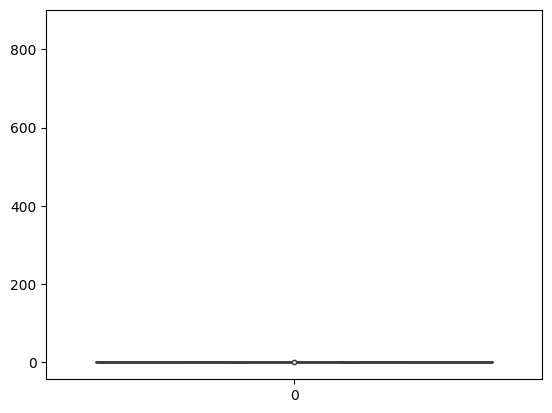

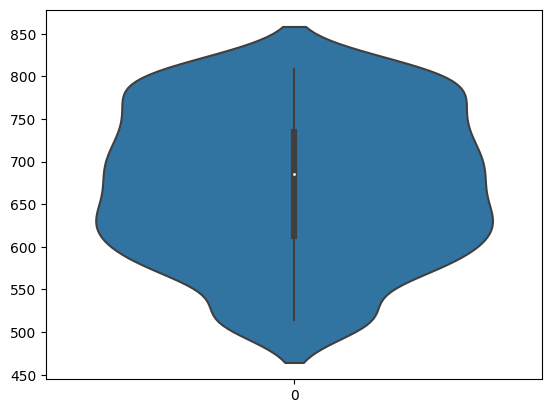

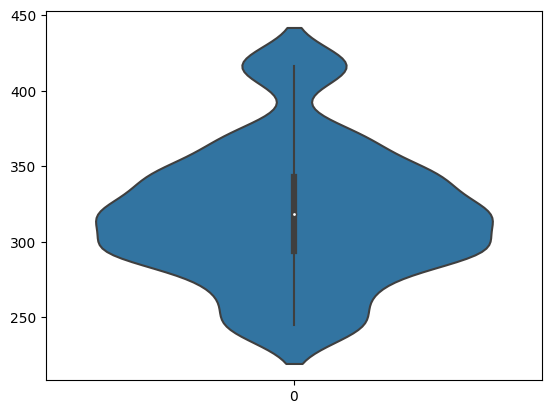

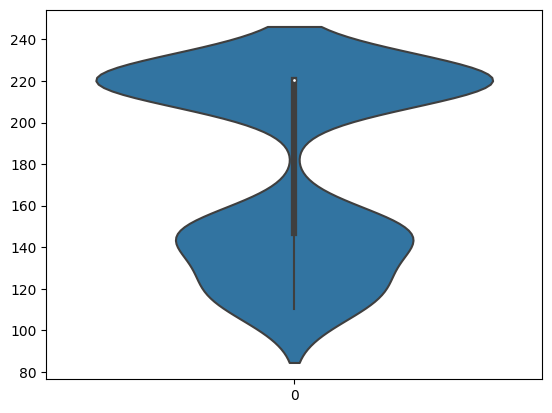

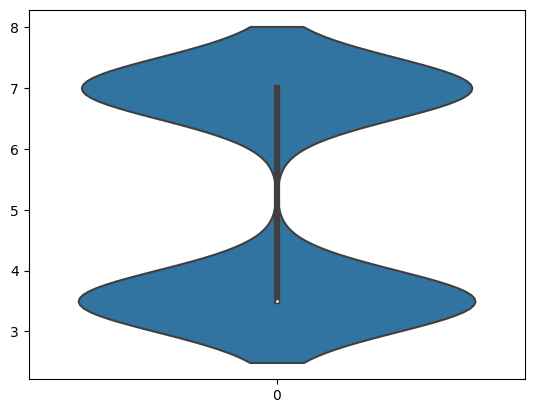

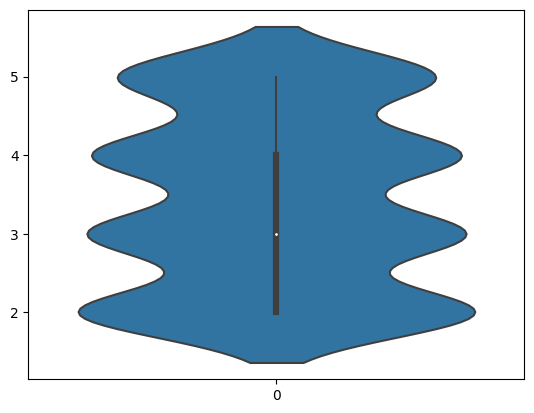

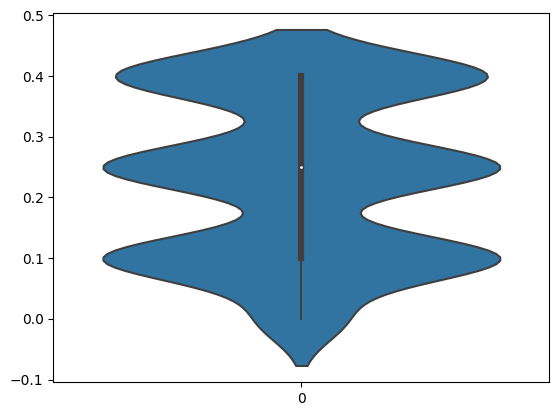

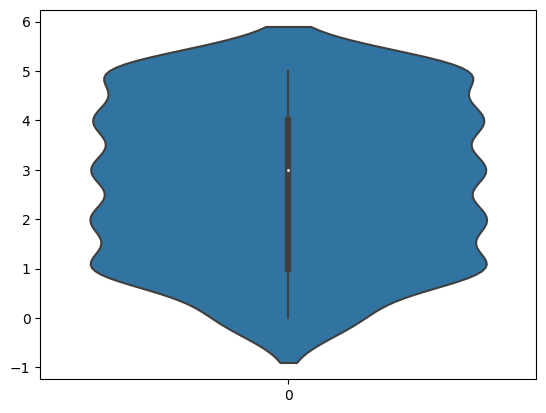

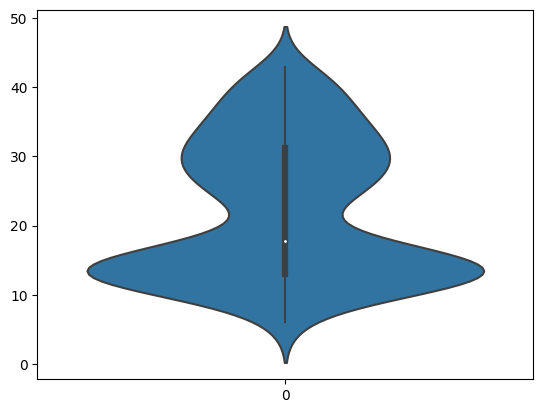

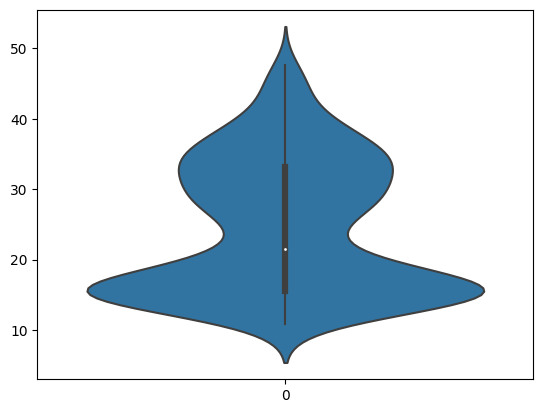

variable0   Q25: 0.69 Q50: 0.74 Q75: 0.82 media: 0.76168 std: 0.10361842307234752
variable1   Q25: 612.5 Q50: 686.0 Q75: 735.0 media: 673.407 std: 86.82063033058445
variable2   Q25: 294.0 Q50: 318.5 Q75: 343.0 media: 318.353 std: 44.05890251697153
variable3   Q25: 147.0 Q50: 220.5 Q75: 220.5 media: 177.527 std: 44.57036875548597
variable4   Q25: 3.5 Q50: 3.5 Q75: 7.0 media: 5.236 std: 1.7499439991039714
variable5   Q25: 2.0 Q50: 3.0 Q75: 4.0 media: 3.416 std: 1.105867984887889
variable6   Q25: 0.1 Q50: 0.25 Q75: 0.4 media: 0.2303 std: 0.13295454110334104
variable7   Q25: 1.0 Q50: 3.0 Q75: 4.0 media: 2.77 std: 1.55983973535745
variable8   Q25: 13.0 Q50: 17.785 Q75: 31.16 media: 22.1638 std: 10.102984685725303
variable9   Q25: 15.59 Q50: 21.5 Q75: 33.155 media: 24.471619999999998 std: 9.590069696076249


In [ ]:
#analisis exploratorio de datos, para chequear la dispercion de datos, si hace falta transformarlos
#y sobre todo si hay outliers, o algo a tener en cuenta

sns.violinplot(data = data)

#para graficar cada violiin por separado

for columna in range(0 , data.shape[1]):

    sns.violinplot(data[:,columna])

    plt.show()

    plt.close()

#para ver la estadistica descriptiva de cada var por separado

for columna in range(0 , data.shape[1]):

    print(f'variable{columna}   Q25: {np.quantile(data[:,columna] , 0.25)} Q50: {np.quantile(data[:,columna] , 0.5)} Q75: {np.quantile(data[:,columna] , 0.75)} media: {np.mean(data[:,columna])} std: {np.std(data[:,columna])}')

Visto que hay variables cuya disperción en valores abosolutos es amplia, decidimos normalizar de diversas formas, y elegimos la más conveniente para este problema de regresión

In [ ]:
#generamos el dataset de input y target como X y Z
X, Z = data[:,:-2], data[:,-2:]

In [ ]:
#normalizacion pesada por el desvio estandar total
mean = np.mean(X, axis=0)
std = np.std(X)
normalized_X_tot = (X - mean) / std
#Total variance
normalized_X_tot_var = (X - mean) / np.square(std)
#normalizacion pesada por el desvio estandar de cada variable
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
normalized_X = (X - mean) / std


In [ ]:
#normalizacion max_min
mean_ = np.mean(X , axis = 0)

min_ = np.ndarray.min(X , axis = 0)

max_ = np.ndarray.max(X , axis = 0)

min_max_X = ((X-min_)/(max_ - min_))

zmean_ = np.mean(Z , axis = 0)

zmin_ = np.ndarray.min(Z , axis = 0)

zmax_ = np.ndarray.max(Z , axis = 0)

min_max_Z = ((Z-zmin_)/(zmax_ - zmin_))

Generamos train y validation sets, para ir probando arquitecturas, y parámetros

In [ ]:
#Generamos dos sets de datos (entrenamiento y validación) para pruebas cortas.
np.random.seed(42)

# Crea array de shuffled indexes
shuffled_indexes = np.random.permutation(len(normalized_X))

# Define split entre train y validation
train_ratio = 0.8  # 80% training, 20% validation

# Calcula num samples para el training set
train_samples = int(train_ratio * len(normalized_X))

# Split  indices en training y validation
train_indexes = shuffled_indexes[:train_samples]
val_indexes = shuffled_indexes[train_samples:]

# Crea training y validation
X_train, z_train = min_max_X[train_indexes], Z[train_indexes]
X_val, z_val = min_max_X[val_indexes], Z[val_indexes]

Prueba de tamaño de batches(secretaría de vialidad nacional)

Size: 2
Pesos: [(9, 2), (3, 2)]
Trained


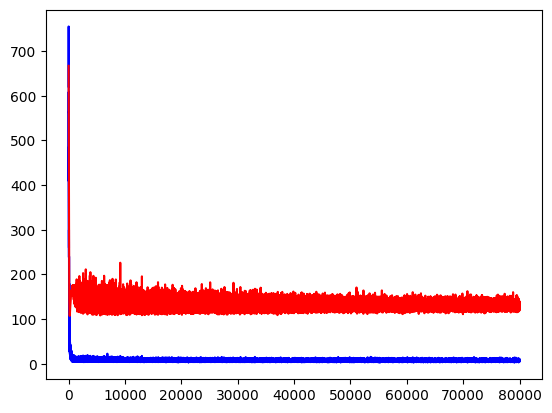

Size: 2
Pesos: [(9, 2), (3, 2)]
Trained


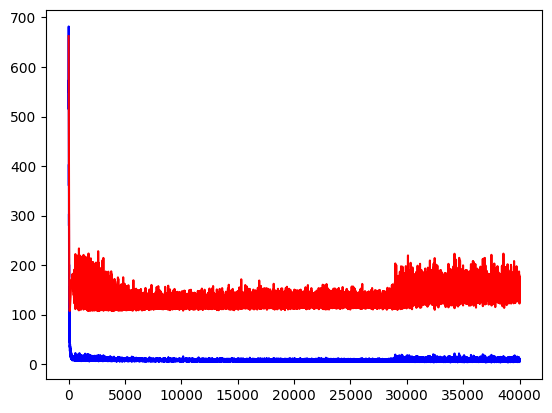

Size: 2
Pesos: [(9, 2), (3, 2)]
Trained


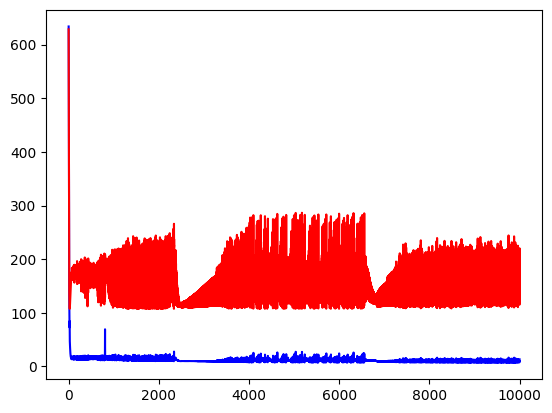

In [ ]:
#Test de batches
modelo_batch_1 = MLP( [2,2] , X_train.shape, ["tanh",'lin'])

modelo_batch_1.train(X_train, z_train, error = 0.01, lr = 0.0001 , batch_size= 50, epochs = 10000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo_batch_1.total_error, color='blue', label='train')
plt.plot(modelo_batch_1.validation_error, color='red', label='validation')
plt.show()
plt.close()
###
modelo_batch_2 = MLP( [2,2] , X_train.shape, ["tanh",'lin'])

modelo_batch_2.train(X_train, z_train, error = 0.01, lr = 0.0001 , batch_size= 100, epochs = 10000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo_batch_2.total_error, color='blue', label='train')
plt.plot(modelo_batch_2.validation_error, color='red', label='validation')
plt.show()
plt.close()
###
modelo_batch_3 = MLP( [2,2] , X_train.shape, ["tanh",'lin'])

modelo_batch_3.train(X_train, z_train, error = 0.01, lr = 0.0001 , batch_size= 500, epochs = 10000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo_batch_3.total_error, color='blue', label='train')
plt.plot(modelo_batch_3.validation_error, color='red', label='validation')
plt.show()
plt.close()

In [ ]:
#CROSS VALIDATION
_ ,train_error, validation_error = cross_val(normalized_X , Z, [18,9,2], ['lin',"tanh",'lin'], NSets = 5, error = 0.01, lr = 0.00001 , batch_size = 50, epochs = 2000, verbose = True, beta = 0)
print(f"Validation mean MSE: {np.mean(validation_error)}")

Size: 3
Pesos: [(9, 18), (19, 9), (10, 2)]
Epoch: 0, Error -> 618.2033413632995
Epoch: 1000, Error -> 16.677726026843764
Epoch: 2000, Error -> 7.94127892812276
Trained
Size: 3
Pesos: [(9, 18), (19, 9), (10, 2)]
Epoch: 0, Error -> 782.9547963560468
Epoch: 1000, Error -> 13.502976652798608
Epoch: 2000, Error -> 8.562141938192692
Trained
Size: 3
Pesos: [(9, 18), (19, 9), (10, 2)]
Epoch: 0, Error -> 568.6936728920783
Epoch: 1000, Error -> 24.513413460869
Epoch: 2000, Error -> 9.382662536066986
Trained
Size: 3
Pesos: [(9, 18), (19, 9), (10, 2)]
Epoch: 0, Error -> 595.9705858150564
Epoch: 1000, Error -> 23.944584531780865
Epoch: 2000, Error -> 3.7649307568849655
Trained
Size: 3
Pesos: [(9, 18), (19, 9), (10, 2)]
Epoch: 0, Error -> 622.3880884868378
Epoch: 1000, Error -> 24.7712656835757
Epoch: 2000, Error -> 9.140179388324581
Trained
181.69895416671943


Size: 3
Pesos: [(9, 18), (19, 9), (10, 2)]
Trained


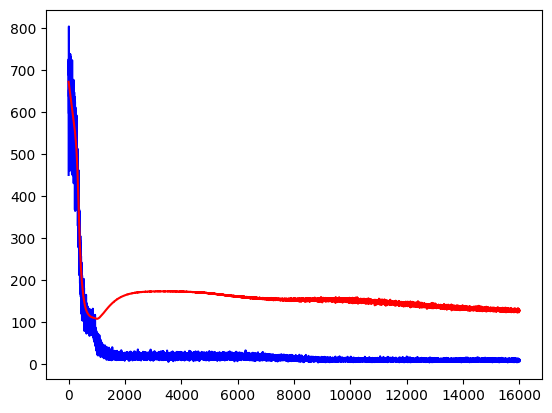

In [ ]:
modelo = MLP( [18,9,2] , X_train.shape, ['lin',"tanh",'lin'])

modelo.train(X_train, z_train, error = 0.01, lr = 0.00001 , batch_size= 50, epochs = 2000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo.total_error, color='blue', label='train')
plt.plot(modelo.validation_error, color='red', label='validation')
plt.show()
plt.close()

In [ ]:
np.mean(np.abs(((modelo.predict(X_val)-z_val)/z_val))*100, axis=0)

array([9.72959895, 7.99765352])

Size: 3
Pesos: [(9, 10), (11, 5), (6, 2)]
Trained


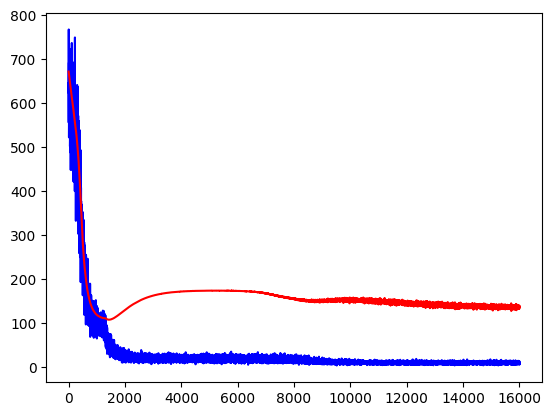

In [ ]:
modelo = MLP( [10,5,2] , X_train.shape, ['lin',"tanh",'lin'])

modelo.train(X_train, z_train, error = 0.01, lr = 0.00001 , batch_size= 50, epochs = 2000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo.total_error, color='blue', label='train')
plt.plot(modelo.validation_error, color='red', label='validation')
plt.show()
plt.close()

In [ ]:
np.mean(np.abs(((modelo.predict(X_val)-z_val)/z_val))*100, axis=0)

array([9.97165553, 8.15666307])

In [ ]:
_ ,train_error, validation_error = cross_val(normalized_X , Z, [8,2], ['lin','lin'], NSets = 5, error = 0.01, lr = 0.00001 , batch_size = 50, epochs = 2000, verbose = True, beta = 0)

Size: 2
Pesos: [(9, 8), (9, 2)]
Epoch: 0, Error -> 772.3434379987941
Epoch: 1000, Error -> 12.0506162259282
Epoch: 2000, Error -> 10.999405905135884
Trained
Size: 2
Pesos: [(9, 8), (9, 2)]
Epoch: 0, Error -> 597.1019474929757
Epoch: 1000, Error -> 15.173207584911992
Epoch: 2000, Error -> 8.790295816418537
Trained
Size: 2
Pesos: [(9, 8), (9, 2)]
Epoch: 0, Error -> 702.8790752373761
Epoch: 1000, Error -> 13.235620215448177
Epoch: 2000, Error -> 7.21612498979252
Trained
Size: 2
Pesos: [(9, 8), (9, 2)]
Epoch: 0, Error -> 731.2903605884817
Epoch: 1000, Error -> 10.337925197116629
Epoch: 2000, Error -> 7.980671645072061
Trained
Size: 2
Pesos: [(9, 8), (9, 2)]
Epoch: 0, Error -> 680.0664189895256
Epoch: 1000, Error -> 13.326536198651718
Epoch: 2000, Error -> 10.28593553117777
Trained


Size: 2
Pesos: [(9, 10), (11, 2)]
Trained


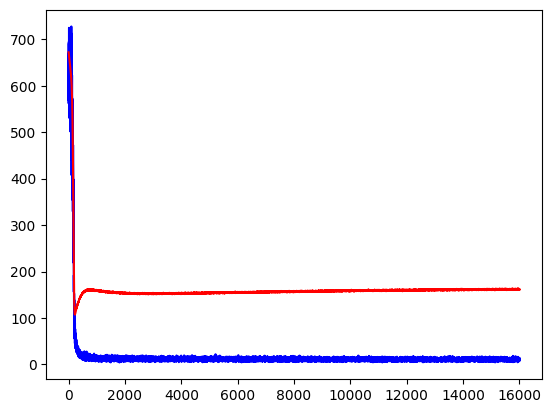

In [ ]:
modelo = MLP( [10,2] , X_train.shape, ['lin','lin'])

modelo.train(X_train, z_train, error = 0.01, lr = 0.00001 , batch_size= 50, epochs = 2000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo.total_error, color='blue', label='train')
plt.plot(modelo.validation_error, color='red', label='validation')
plt.show()
plt.close()

In [ ]:
np.mean(np.abs(((modelo.predict(X_val)-z_val)/z_val))*100, axis=0)

array([11.96414707, 10.21434749])

In [ ]:
_ ,train_error, validation_error = cross_val(normalized_X , Z, [10,2], ['tanh','lin'], NSets = 5, error = 0.01, lr = 0.00001 , batch_size = 50, epochs = 2000, verbose = True, beta = 0)

Size: 2
Pesos: [(9, 10), (11, 2)]
Epoch: 0, Error -> 543.1321623029835
Epoch: 1000, Error -> 9.970168070503968
Epoch: 2000, Error -> 3.9373098104677653
Trained
Size: 2
Pesos: [(9, 10), (11, 2)]
Epoch: 0, Error -> 594.6129771496276
Epoch: 1000, Error -> 8.611994974096447
Epoch: 2000, Error -> 4.657138310374398
Trained
Size: 2
Pesos: [(9, 10), (11, 2)]
Epoch: 0, Error -> 722.9945042124782
Epoch: 1000, Error -> 7.163622968649183
Epoch: 2000, Error -> 3.995523410463507
Trained
Size: 2
Pesos: [(9, 10), (11, 2)]
Epoch: 0, Error -> 657.8750054935612
Epoch: 1000, Error -> 9.159260276881437
Epoch: 2000, Error -> 5.13584302015728
Trained
Size: 2
Pesos: [(9, 10), (11, 2)]
Epoch: 0, Error -> 613.8427882648831
Epoch: 1000, Error -> 7.830031604189968
Epoch: 2000, Error -> 3.3109589118072393
Trained


Size: 2
Pesos: [(9, 10), (11, 2)]
Trained


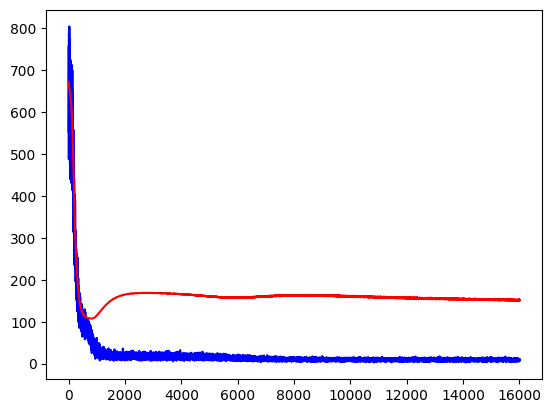

In [ ]:
modelo = MLP( [8,2] , X_train.shape, ['tanh','lin'])

modelo.train(X_train, z_train, error = 0.01, lr = 0.00001 , batch_size= 50, epochs = 2000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo.total_error, color='blue', label='train')
plt.plot(modelo.validation_error, color='red', label='validation')
plt.show()
plt.close()

In [ ]:
np.mean(np.abs(((modelo.predict(X_val)-z_val)/z_val))*100, axis=0)

array([9.45666298, 7.75777074])

In [ ]:
_ ,train_error, validation_error = cross_val(normalized_X , Z, [5,2], ['tanh','lin'], NSets = 5, error = 0.01, lr = 0.00001 , batch_size = 50, epochs = 2000, verbose = True, beta = 0)

Size: 2
Pesos: [(9, 5), (6, 2)]
Epoch: 0, Error -> 751.7101759064067
Epoch: 1000, Error -> 13.478834943856254
Epoch: 2000, Error -> 6.116537775338497
Trained
Size: 2
Pesos: [(9, 5), (6, 2)]
Epoch: 0, Error -> 530.7574814045713
Epoch: 1000, Error -> 10.516590305079674
Epoch: 2000, Error -> 6.000330378210652
Trained
Size: 2
Pesos: [(9, 5), (6, 2)]
Epoch: 0, Error -> 547.5648183431874
Epoch: 1000, Error -> 11.071501953484821
Epoch: 2000, Error -> 5.9660120137144546
Trained
Size: 2
Pesos: [(9, 5), (6, 2)]
Epoch: 0, Error -> 639.851013068826
Epoch: 1000, Error -> 11.596538194710407
Epoch: 2000, Error -> 8.878427988088342
Trained
Size: 2
Pesos: [(9, 5), (6, 2)]
Epoch: 0, Error -> 750.3432632179699
Epoch: 1000, Error -> 15.066502320853902
Epoch: 2000, Error -> 8.570071663632945
Trained


Size: 2
Pesos: [(9, 5), (6, 2)]
Trained


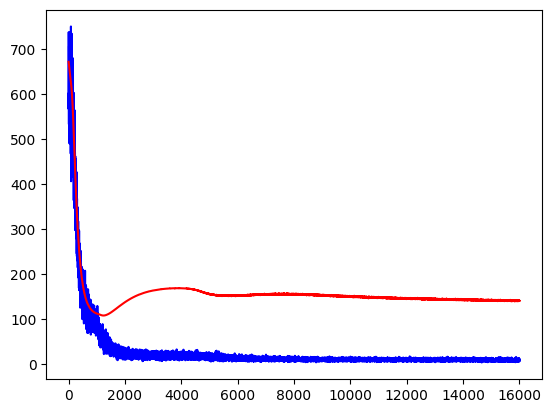

In [ ]:
modelo = MLP( [5,2] , X_train.shape, ['tanh','lin'])

modelo.train(X_train, z_train, error = 0.01, lr = 0.00001 , batch_size= 50, epochs = 2000, validation = (X_val, z_val), verbose = False)

plt.plot(modelo.total_error, color='blue', label='train')
plt.plot(modelo.validation_error, color='red', label='validation')
plt.show()
plt.close()

In [ ]:
np.mean(np.abs(((modelo.predict(X_val)-z_val)/z_val))*100, axis=0)

array([9.11982465, 7.92738523])

In [ ]:
_ ,train_error, validation_error = cross_val(normalized_X , Z, [1,2], ['tanh','lin'], NSets = 5, error = 0.01, lr = 0.00001 , batch_size = 50, epochs = 2000, verbose = True, beta = 0)

Size: 2
Pesos: [(9, 1), (2, 2)]
Epoch: 0, Error -> 575.8539372071102
Epoch: 1000, Error -> 16.615671725275465
Epoch: 2000, Error -> 16.945920549989218
Trained
Size: 2
Pesos: [(9, 1), (2, 2)]
Epoch: 0, Error -> 628.844276222487
Epoch: 1000, Error -> 17.330438659892753
Epoch: 2000, Error -> 14.384258599075302
Trained
Size: 2
Pesos: [(9, 1), (2, 2)]
Epoch: 0, Error -> 620.1884847409813
Epoch: 1000, Error -> 18.13002027288343
Epoch: 2000, Error -> 18.3503505466248
Trained
Size: 2
Pesos: [(9, 1), (2, 2)]
Epoch: 0, Error -> 662.0034066304956
Epoch: 1000, Error -> 21.6950912540186
Epoch: 2000, Error -> 21.318653908668797
Trained
Size: 2
Pesos: [(9, 1), (2, 2)]
Epoch: 0, Error -> 653.1443614498285
Epoch: 1000, Error -> 15.285368865239741
Epoch: 2000, Error -> 13.968818454150489
Trained


Size: 2
Pesos: [(9, 8), (9, 2)]
Trained


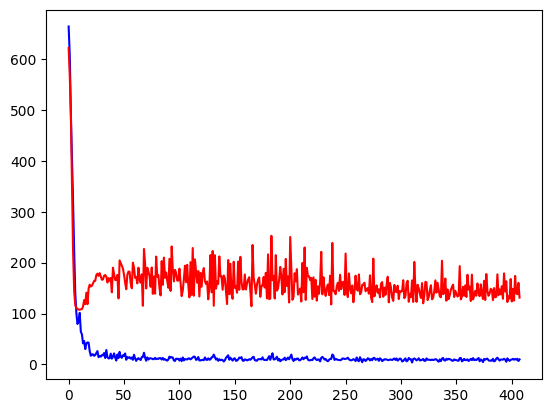

In [ ]:
modelo = MLP( [8,2] , X_train.shape, ['tanh','lin'])

modelo.train(X_train, z_train, error = 0.01, lr = 0.001 , batch_size= 50, epochs = 50, validation = (X_val, z_val),beta= 0.1, verbose = False)

plt.plot(modelo.total_error, color='blue', label='train')
plt.plot(modelo.validation_error, color='red', label='validation')
plt.show()
plt.close()

In [ ]:
models ,train_error, validation_error = cross_val(normalized_X , Z, [8,2], ['tanh','lin'], NSets = 5, error = 0.01, lr = 0.00001 , batch_size = 50, epochs = 2000, verbose = True, beta = 0)

cross_val_mean_MSE(validation_error)

Size: 2
Pesos: [(9, 8), (9, 2)]
Epoch: 0, Error -> 536.3288993100513
Epoch: 1000, Error -> 7.4385431848337635
Epoch: 2000, Error -> 6.502900616054584
Trained
Size: 2
Pesos: [(9, 8), (9, 2)]
Epoch: 0, Error -> 624.0298089312639
Epoch: 1000, Error -> 4.274498936357144
Epoch: 2000, Error -> 3.3349426375786404
Trained
Size: 2
Pesos: [(9, 8), (9, 2)]
Epoch: 0, Error -> 747.7882792188788
Epoch: 1000, Error -> 8.730766514804932
Epoch: 2000, Error -> 5.829341121795612
Trained
Size: 2
Pesos: [(9, 8), (9, 2)]
Epoch: 0, Error -> 622.5830552471373
Epoch: 1000, Error -> 8.044238219175618
Epoch: 2000, Error -> 5.852997273353554
Trained
Size: 2
Pesos: [(9, 8), (9, 2)]
Epoch: 0, Error -> 657.7250029410164
Epoch: 1000, Error -> 7.338609212272031
Epoch: 2000, Error -> 4.8115880505762485
Trained


185.91757056840584

<Axes: ylabel='Density'>

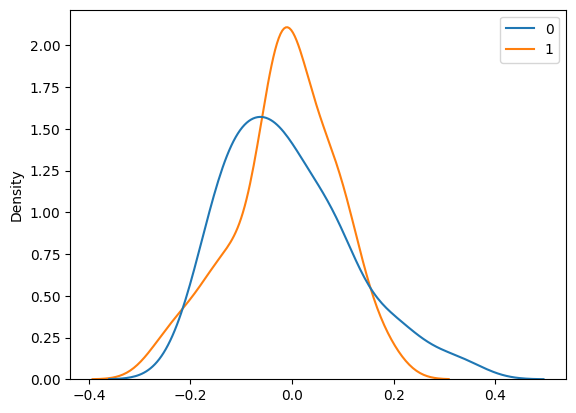

In [ ]:
import seaborn as sns
diferencia_mod = modelo.predict(X_val[:])-z_val[:]

la_posta = z_val[:]

ratio = diferencia_mod/la_posta

sns.kdeplot(ratio)

Con este gráfico, representamos que los errores están centrados en 0, y se distribuyen al azar, de una manera bastante simétrica. siendo mayoritariamente cero el error que se ve.

Vamos a entrenar al mejor modelo qaue logramos generar, con todos los datos.

In [ ]:
mejor_modelo = MLP( [8,2] , X.shape, ['tanh','lin'])

mejor_modelo.train(normalized_X, Z, error = 0.01, lr = 0.0001 , batch_size = 25, epochs = 3000, beta = 0, verbose = False, validation = False)

Size: 2
Pesos: [(9, 8), (9, 2)]
Trained


<Axes: ylabel='Density'>

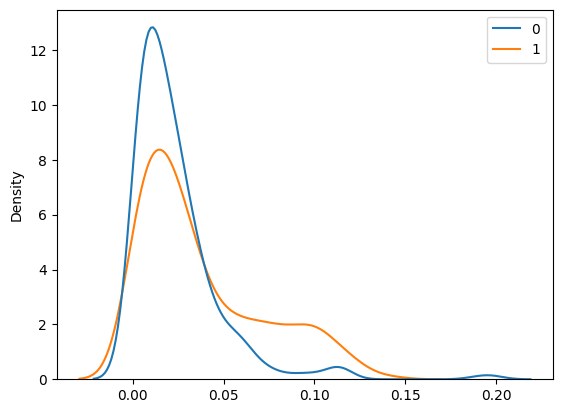

In [ ]:
sns.kdeplot(np.abs((mejor_modelo.predict(normalized_X)[:]-Z[:])/Z[:]))
#esto grafica la densidad de la diferencia absoluta entre prediho, y observado, divido obserbado

### TESTEO DE LA MEJOR ARQUITECTURA ENCONTRADA

Finalmente nos decantamos por esta arquitectura y entrenamos la red con todos los datos. Luego de correr el notebook entero, la celda debajo permite ingresar datos de testeo y checkear la performance de la red.

In [ ]:
# INSERTAR DATOS DE TESTEO PARA CALCULAR MÉTRICAS
# Gus_X_test =
# Gus_z_test =

y_pred = mejor_modelo.predict(Gus_X_test)

sns.kdeplot(np.abs((y_pred[:]-Gus_z_test[:])/Gus_z_test[:]))